# Baseball Pitch Type Classification with Transformers
This notebook implements a Transformer-based model to classify baseball pitch types. We preprocess the data, perform hyperparameter tuning, and evaluate the model's performance.

## Libraries and Setup
We use:
- **Pandas**: For data manipulation.
- **NumPy**: For numerical operations.
- **TensorFlow/Keras**: For building and training the Transformer model.
- **Keras Tuner**: For hyperparameter optimization.
- **Matplotlib/Seaborn**: For visualization.

Additionally, errors are suppressed to produce cleaner output.

In [1]:
# Import Required Libraries
import os
import warnings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress TensorFlow logs

import keras_tuner as kt
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (
    Embedding,
    Dropout,
    LayerNormalization,
    Dense,
    MultiHeadAttention,
    Input,
    GlobalAveragePooling1D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Data Loading and Preprocessing
The dataset consists of baseball pitches. We preprocess it to:
1. **Handle Missing Data**: Drop rows with missing target labels (`pitch_type`).
2. **Filter Rare Classes**: Retain classes with more than 50 samples.
3. **Feature Engineering**: Add features for score difference, runners in scoring position, and handedness matchups.
4. **Prepare Sequential Data**: Group data by innings and pitcher, and pad sequences to ensure uniformity.

These steps prepare the data for input into a Transformer-based model.

In [2]:
# Load and Preprocess Data
data = pd.read_csv("pitches.csv")

# Drop rows with NaN in 'pitch_type' (target)
data = data.dropna(subset=["pitch_type"])

# Filter out rare classes
class_counts = data["pitch_type"].value_counts()
data = data[data["pitch_type"].isin(class_counts[class_counts > 50].index)]

# Encode target variable
label_encoder = LabelEncoder()
data["pitch_type_encoded"] = label_encoder.fit_transform(data["pitch_type"])

# Feature engineering
data["score_diff"] = np.where(
    data["top"] == 1,
    data["away_team_runs"] - data["home_team_runs"],
    data["home_team_runs"] - data["away_team_runs"]
)
data["runner_in_scoring_position"] = ((data["on_2b"] > 0) | (data["on_3b"] > 0)).astype(int)
data["handedness_matchup"] = np.where(
    ((data["stand"] == "L") & (data["p_throws"] == "R")) |
    ((data["stand"] == "R") & (data["p_throws"] == "L")),
    1,
    0
)

# Select relevant columns
relevant_columns = [
    "inning", "top", "pcount_at_bat", "pcount_pitcher",
    "outs", "balls", "strikes", "score_diff",
    "runner_in_scoring_position", "handedness_matchup"
]
X = data[relevant_columns].values
y = data["pitch_type_encoded"]

# Prepare Sequential Data
sequences = data.groupby(["inning", "pitcher_id"]).apply(
    lambda x: list(x["pitch_type_encoded"])
).tolist()
max_seq_length = 30
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding="post", value=-1)

X = padded_sequences[:, :-1]
y = padded_sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=len(label_encoder.classes_))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Transformer Block and Positional Encoding
The Transformer model includes:
1. **Multi-Head Attention**: Captures dependencies between sequences.
2. **Feed-Forward Networks**: Adds non-linearity and capacity to the model.
3. **Layer Normalization**: Stabilizes training.
4. **Dropout Regularization**: Mitigates overfitting.

We also add positional encodings to provide sequence order information.

In [3]:
# Transformer Block Definition
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Positional Encoding
def positional_encoding(seq_len, embed_dim):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(embed_dim)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / embed_dim)
    pos_enc = pos * angle_rates
    pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
    pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])
    return pos_enc

## Hyperparameter Tuning with Keras Tuner
We utilize Keras Tuner's Hyperband algorithm to find the best combination of hyperparameters. The hyperparameters being tuned include:
- **Embedding Dimension (`embed_dim`)**: Controls the size of the embedding vectors.
- **Number of Attention Heads (`num_heads`)**: Defines the number of parallel attention mechanisms.
- **Feedforward Dimension (`ff_dim`)**: Determines the size of the intermediate feedforward layer.
- **Dropout Rate (`dropout_rate`)**: Helps prevent overfitting by randomly deactivating neurons during training.

The tuning process evaluates various combinations to optimize validation accuracy.

In [4]:
# Define a function to build the model for tuning
def build_model(hp):
    embed_dim = hp.Int("embed_dim", min_value=32, max_value=128, step=32)
    num_heads = hp.Int("num_heads", min_value=2, max_value=8, step=2)
    ff_dim = hp.Int("ff_dim", min_value=64, max_value=256, step=64)
    dropout_rate = hp.Choice("dropout_rate", values=[0.1, 0.3, 0.5])
    
    inputs = Input(shape=(max_seq_length - 1,))
    embedding_layer = Embedding(input_dim=len(label_encoder.classes_), output_dim=embed_dim)
    x = embedding_layer(inputs)
    x = x + tf.convert_to_tensor(positional_encoding(max_seq_length - 1, embed_dim), dtype=tf.float32)
    
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout_rate)
    x = transformer_block(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(len(label_encoder.classes_), activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Configure the tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=10,
    factor=3,
    directory="hyperband_tuning",
    project_name="pitch_transformer",
)

# Perform the search
tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    verbose=1
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Embedding Dimension: {best_hps.get('embed_dim')}")
print(f"Best Number of Attention Heads: {best_hps.get('num_heads')}")
print(f"Best Feedforward Dimension: {best_hps.get('ff_dim')}")
print(f"Best Dropout Rate: {best_hps.get('dropout_rate')}")

Reloading Tuner from hyperband_tuning/pitch_transformer/tuner0.json
Best Embedding Dimension: 32
Best Number of Attention Heads: 2
Best Feedforward Dimension: 64
Best Dropout Rate: 0.1


## Building and Training the Best Model
After hyperparameter tuning, we use the best configuration to build and train the model. The model is trained for 10 epochs, using the best hyperparameter settings identified by Keras Tuner.

In [5]:
# Build the best model with tuned hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    verbose=1,
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Best Model Test Accuracy: {accuracy:.2f}")

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3462 - loss: 2.1738 - val_accuracy: 0.4745 - val_loss: 1.5542
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5106 - loss: 1.4589 - val_accuracy: 0.5839 - val_loss: 1.1814
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5950 - loss: 1.1632 - val_accuracy: 0.5881 - val_loss: 1.1299
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5787 - loss: 1.1743 - val_accuracy: 0.5860 - val_loss: 1.1180
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5832 - loss: 1.1228 - val_accuracy: 0.5987 - val_loss: 1.0724
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5917 - loss: 1.1089 - val_accuracy: 0.5987 - val_loss: 1.0558
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6016 - loss: 1.0804 - val_accuracy: 0.5924 - val_loss: 1.0555
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5956 - loss: 1.0910 - val_accuracy: 0.5987 - v

## Visualizing Model Performance
We plot:
1. **Training and Validation Accuracy**: To observe the model's learning progress.
2. **Training and Validation Loss**: To detect overfitting or underfitting.

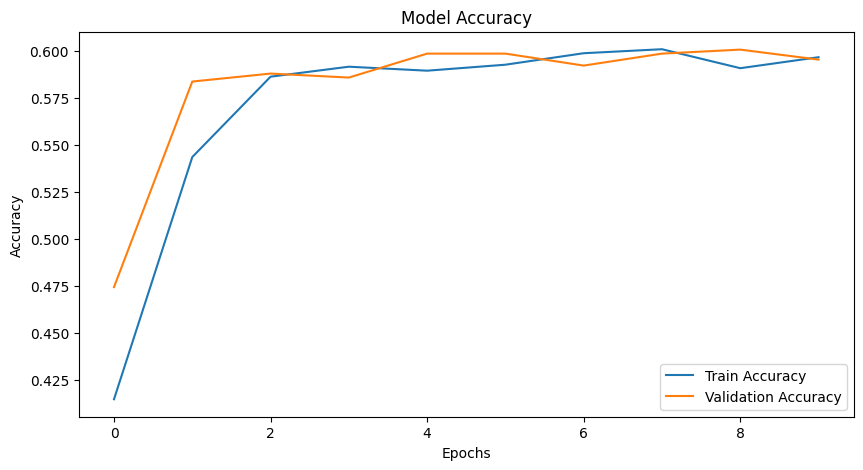

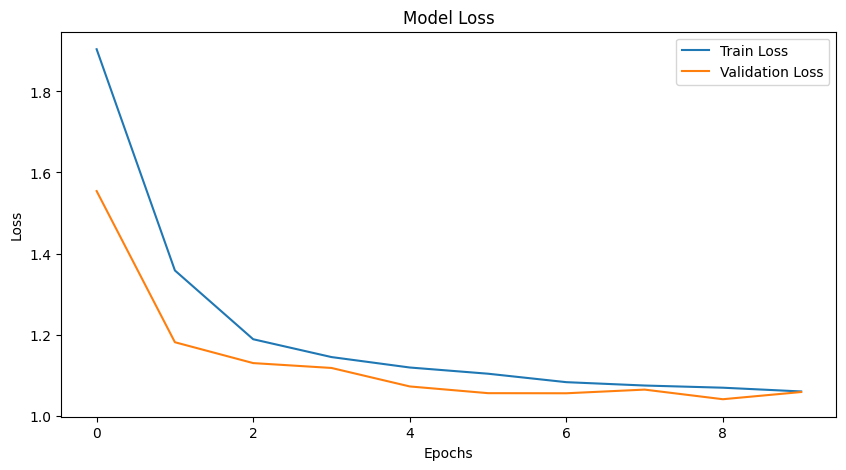

In [6]:
# Model Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Model Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Future Steps
If more time and resources were available, future improvements could include:
1. **Feature Expansion**: Incorporating additional contextual features such as previous pitch speed, previous spin rate, or environmental conditions.
2. **Data Augmentation**: Generating synthetic samples for underrepresented pitch types to balance the dataset.
3. **Model Architecture Exploration**: Testing advanced models like BERT or GPT-like architectures tailored for sequential tasks.
4. **Ensemble Models**: Combining multiple Transformer models or other architectures for improved performance.
5. **Domain-Specific Embeddings**: Using pre-trained embeddings fine-tuned for baseball data.
6. **Deployment**: Packaging the model for real-time predictions with an API or web interface.